In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment/dataset/sample_submission.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_885.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_698.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1176.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1215.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_66.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_386.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1026.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_330.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_858.wav
/kaggle/input/shl-intern-hiring-ass

In [2]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# File paths

In [3]:
TRAIN_PATH = '/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv'
TEST_PATH = '/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv'
TRAIN_AUDIO_DIR = '/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train/'
TEST_AUDIO_DIR = '/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/'
SUBMISSION_TEMPLATE = '/kaggle/input/shl-intern-hiring-assessment/dataset/sample_submission.csv'


🎙️ SHL Grammar Scoring Engine - Improved Version
Loaded 444 training samples and 195 test samples

📊 Extracting features from training data...
Processing 0/444 files...
Processing 50/444 files...
Processing 100/444 files...
Processing 150/444 files...
Processing 200/444 files...
Processing 250/444 files...
Processing 300/444 files...
Processing 350/444 files...
Processing 400/444 files...
Extracted features shape: (444, 240)
Labels shape: (444,)
Training set: 355 samples
Validation set: 89 samples

🧠 Training model...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
=== Validation Evaluation ===
Mean Squared Error: 0.8838
R² Score: 0.3516
Pearson Correlation: 0.6350

🔄 Retraining on full dataset...
=== Full Training Evaluation ===
Mean Squared Error: 0.1023
R² Score: 0.9174
Pearson Correlation: 0.9814


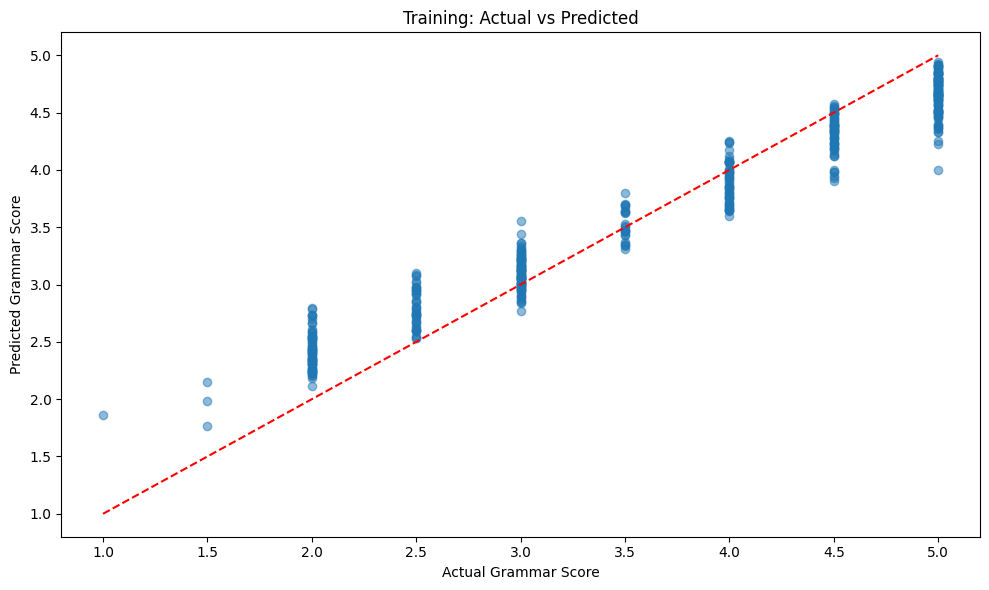

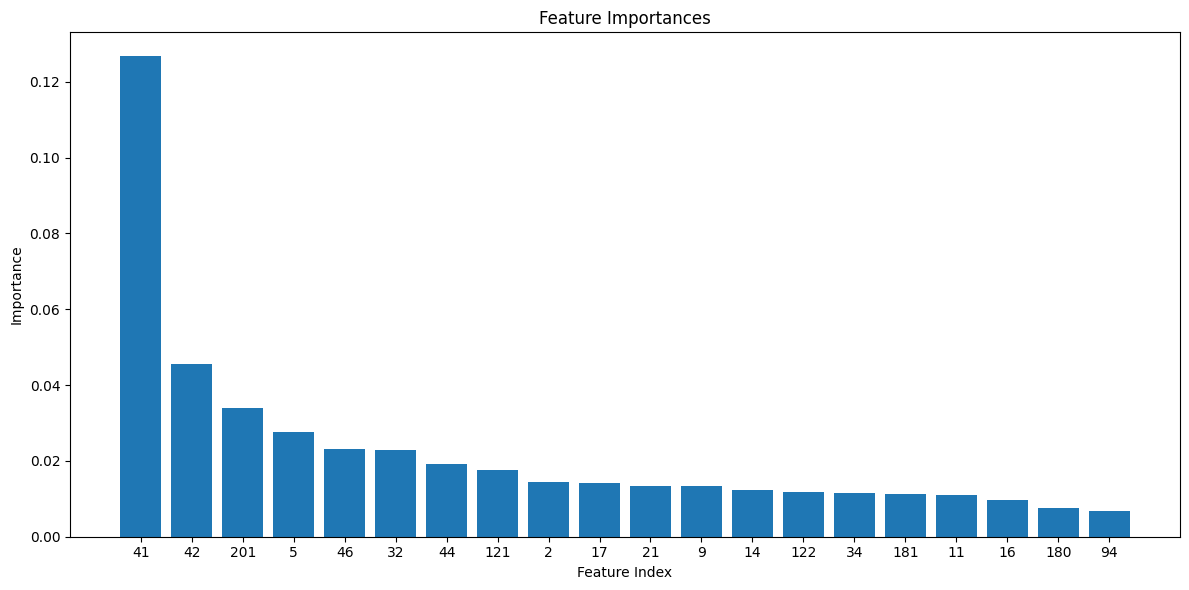


📊 Extracting features from test data...
Processing 0/195 files...
Processing 50/195 files...
Processing 100/195 files...
Processing 150/195 files...
Extracted features shape: (195, 240)

🔮 Generating predictions for test set...
Test prediction stats - Min: 2.25, Max: 4.74


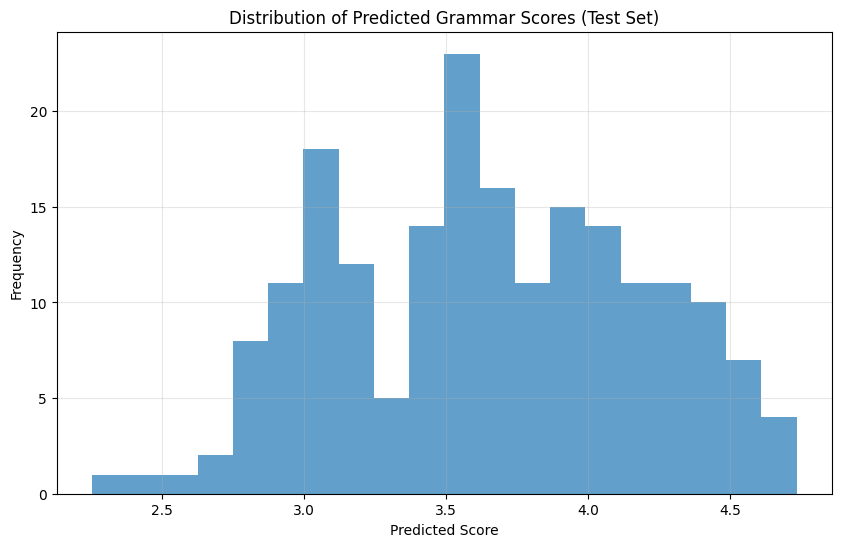


✅ Final submission saved as 'submission.csv'
         filename   label
0   audio_706.wav  2.8800
1   audio_800.wav  2.8375
2    audio_68.wav  4.0650
3  audio_1267.wav  3.5950
4   audio_683.wav  2.8300


In [4]:

def load_data():
    """Load and return training and test dataframes"""
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)
    print(f"Loaded {len(train_df)} training samples and {len(test_df)} test samples")
    return train_df, test_df

def extract_features(file_path, n_mfcc=40, add_delta=True):
    """
    Extract audio features using librosa
    
    Parameters:
    - file_path: Path to audio file
    - n_mfcc: Number of MFCC coefficients to extract
    - add_delta: Whether to add delta and delta-delta features
    
    Returns:
    - Feature vector
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=None)
        
        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        # Get statistics from MFCCs
        mfcc_features = np.hstack((
            np.mean(mfcc.T, axis=0),
            np.std(mfcc.T, axis=0)
        ))
        
        # Add delta and delta-delta features if requested
        if add_delta:
            delta_mfcc = librosa.feature.delta(mfcc)
            delta2_mfcc = librosa.feature.delta(mfcc, order=2)
            
            delta_features = np.hstack((
                np.mean(delta_mfcc.T, axis=0),
                np.std(delta_mfcc.T, axis=0)
            ))
            
            delta2_features = np.hstack((
                np.mean(delta2_mfcc.T, axis=0),
                np.std(delta2_mfcc.T, axis=0)
            ))
            
            return np.hstack((mfcc_features, delta_features, delta2_features))
        
        return mfcc_features
        
    except Exception as e:
        print(f"Error extracting features from {file_path}: {str(e)}")
        # Return zeros in case of error
        feature_size = n_mfcc * 2 * (3 if add_delta else 1)
        return np.zeros(feature_size)

def extract_features_batch(df, audio_dir, verbose=True):
    """Extract features from all audio files in dataframe"""
    features = []
    labels = []
    
    total = len(df)
    for i, (_, row) in enumerate(df.iterrows()):
        if verbose and i % 50 == 0:
            print(f"Processing {i}/{total} files...")
            
        path = os.path.join(audio_dir, row['filename'])
        feature_vector = extract_features(path)
        features.append(feature_vector)
        
        if 'label' in row:
            labels.append(row['label'])
    
    X = np.array(features)
    y = np.array(labels) if labels else None
    
    if verbose:
        print(f"Extracted features shape: {X.shape}")
        if y is not None:
            print(f"Labels shape: {y.shape}")
    
    return X, y

def train_model(X_train, y_train, X_val=None, y_val=None):
    """Train and optionally tune the model"""
    if X_val is not None and y_val is not None:
        # If validation data is provided, use GridSearchCV for hyperparameter tuning
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
        
        model = GridSearchCV(
            RandomForestRegressor(random_state=42),
            param_grid,
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=1,
            n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        print(f"Best parameters: {model.best_params_}")
        best_model = model.best_estimator_
    else:
        # Otherwise, use default parameters
        best_model = RandomForestRegressor(
            n_estimators=200,
            max_depth=None,
            min_samples_split=2,
            random_state=42
        )
        best_model.fit(X_train, y_train)
    
    return best_model

def evaluate_model(model, X, y, set_name=""):
    """Evaluate model on provided data"""
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    pearson_corr, _ = pearsonr(y, y_pred)
    
    print(f"=== {set_name} Evaluation ===")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Pearson Correlation: {pearson_corr:.4f}")
    
    return mse, r2, pearson_corr, y_pred

def visualize_predictions(y_true, y_pred, title="Actual vs Predicted"):
    """Create a scatter plot of actual vs predicted values"""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel("Actual Grammar Score")
    plt.ylabel("Predicted Grammar Score")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def feature_importance(model, feature_size):
    """Visualize feature importance"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(feature_size), importances[indices[:feature_size]])
    plt.xticks(range(feature_size), indices[:feature_size])
    plt.xlabel("Feature Index")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

def main():
    print("🎙️ SHL Grammar Scoring Engine - Improved Version")
    
    # Step 1: Load data
    train_df, test_df = load_data()
    
    # Step 2: Extract features
    print("\n📊 Extracting features from training data...")
    X_train_full, y_train_full = extract_features_batch(train_df, TRAIN_AUDIO_DIR)
    
    # Step 3: Split training data for validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42
    )
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    
    # Step 4: Train model
    print("\n🧠 Training model...")
    model = train_model(X_train, y_train, X_val, y_val)
    _, _, _, _ = evaluate_model(model, X_val, y_val, "Validation")
    
    # Step 6: Retrain on full dataset
    print("\n🔄 Retraining on full dataset...")
    final_model = train_model(X_train_full, y_train_full)
    
    # Step 7: Evaluate on full training set
    _, _, _, train_preds = evaluate_model(final_model, X_train_full, y_train_full, "Full Training")
    # Step 8: Visualize results
    visualize_predictions(y_train_full, train_preds, "Training: Actual vs Predicted")
    
    # Step 9: Show feature importance
    feature_importance(final_model, 20)  # Show top 20 features
    
    # Step 10: Extract features from test data
    print("\n📊 Extracting features from test data...")
    X_test, _ = extract_features_batch(test_df, TEST_AUDIO_DIR)
    
    # Step 11: Generate predictions for test set
    print("\n🔮 Generating predictions for test set...")
    test_predictions = final_model.predict(X_test)
    
    # Step 12: Display prediction statistics
    print(f"Test prediction stats - Min: {min(test_predictions):.2f}, Max: {max(test_predictions):.2f}")

     # Step 13: Create histogram of predictions
    plt.figure(figsize=(10, 6))
    plt.hist(test_predictions, bins=20, alpha=0.7)
    plt.title("Distribution of Predicted Grammar Scores (Test Set)")
    plt.xlabel("Predicted Score")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()
     # Step 14: Create submission file
    submission = pd.read_csv(SUBMISSION_TEMPLATE)
    submission['label'] = test_predictions
    submission.to_csv("submission.csv", index=False)
    print("\n✅ Final submission saved as 'submission.csv'")
    print(submission.head())

if __name__ == "__main__":
    main()